# Introducción

El modelo central utilizado en este proyecto es un Árbol de Decisión (Decision Tree Classifier), entrenado sobre una representación enriquecida del texto que combina embeddings TF-IDF con bigramas y un componente adicional de análisis de sentimiento escalado. Esta configuración fue integrada a un pipeline completo que incluyó limpieza, normalización, lematización del texto y codificación de la variable objetivo.

El objetivo del modelo es detectar publicaciones relacionadas con anorexia a partir de contenido escrito en redes sociales. Dado el carácter clínico y sensible del problema, se definieron criterios de evaluación con un enfoque en la minimización del riesgo y el valor práctico para escenarios de intervención o monitoreo en salud mental.

Se priorizó el uso del AUC (Área bajo la curva ROC) como métrica central, ya que permite evaluar de forma robusta la capacidad del modelo para distinguir entre publicaciones de riesgo (anorexia) y publicaciones neutras o saludables (control), sin verse afectado por el desbalance entre clases.

Además, se enfatizó el recall como métrica crítica, dado que en un contexto de salud mental es fundamental identificar la mayor cantidad posible de casos verdaderamente positivos. Minimizar falsos negativos es una prioridad para no pasar por alto señales de advertencia reales.

En paralelo, se consideró la precisión como herramienta para monitorear la proporción de predicciones positivas que efectivamente correspondían a la categoría de riesgo. Esto ayuda a evitar respuestas innecesarias o sobrecarga de atención.

Por último, el F1 score se empleó como métrica balanceada entre precisión y recall, proporcionando una visión integral del rendimiento del modelo en un problema de clasificación binaria en donde ambas tasas de error (falsos positivos y negativos) deben ser cuidadosamente gestionadas.

# Importación de Librerías

In [1]:
!pip install scikit-learn

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, f1_score
import pandas as pd

# Exploración de información

In [8]:
data = pd.read_csv('data_train(in).csv')

In [9]:
data.head()

,tweet_id,tweet_text,class
0,0d3ed29586ce,Cheesecake saludable sin azúcar y sin lactosa ...,control
1,c3cf897a495b,ser como ellas ♡♡\n #HastaLosHuesos,anorexia
2,5041d85c45c6,"Comida Real o , la clave para estar más sana, ...",control
3,d18285d3c7ec,Entre el cambio de hora y la bajada de las #te...,control
4,4d81892f3217,Hace mucho tiempo no sentía mi cuerpo tan frío,anorexia


In [10]:
data.tweet_text.value_counts()

,count
tweet_text,
1er día\n* Dos latas de coca cola light \n* Litro & medio de agua pura\n* Tres tazas de té sin azúcar...\n\n #ayuno #Ana #Princesa,1
Cheesecake saludable sin azúcar y sin lactosa con mermerlada casera de moras,1
ser como ellas ♡♡\n #HastaLosHuesos,1
"Comida Real o , la clave para estar más sana, delgada y feliz \n\nhttps://www.modalia.es/estilo-de-vida/15192-comida-real-o-real-food-la-clave-para-estar-mas-sana-delgada-y-feliz.html …",1
"Entre el cambio de hora y la bajada de las #temperaturas estamos destemplados, por eso os recomendamos un buen plato de #fabada #casera para entonar el cuerpo #decasa #platoscuchara #madridrio #gastro #arganzuela",1
...,...
Cambiar la comida por el alcohol,1
Norex Anfepromona un potente medicamento para dejar de comer en exceso\nADELGAZA SIN HAMBRE\n#TusClásicos #SabadoDeGanarSeguidores #EsPuenteYTodos #bellezasuperior\n#TwitterBestFandom\n#SoompiAwards\n#ConvoyVL19\n#20anosVL19 #Tampico #Dieta #Obesidad #Madero #Tamaulipas #Fit,1
"Los huesos que se me notan, son la copa, la medalla, por haberte ganado la batalla.\n.",1


# Limpieza de datos

In [11]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

In [12]:
!python -m spacy download es_core_news_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 126.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [13]:
import spacy

nlp = spacy.load('es_core_news_sm')

def clean_text_lemmatization(text):
    """
    Funciona que limpia y lematiza un texto en español aplicando los siguientes pasos:

    1. Convierte el texto a minúsculas
    2. Elimina URLs (http, https, www)
    3. Quita el símbolo '#'
    4. Elimina caracteres especiales
    5. Elimina espacios duplicados
    6. Aplica lematización con spaCy y remueve stopwords

    Parámetros:
        text (str): Texto original a procesar.

    Retorna:
        str: Texto limpio y lematizado, separado por espacios.
    """
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"#(\w+)", r"\1", text)
    text = re.sub(r"[^a-záéíóúñü\s]", '', text)
    text = re.sub(r"\s+", ' ', text).strip()

    doc = nlp(text)
    lemmatized_tokens = [
        token.lemma_ for token in doc if not token.is_stop
    ]

    return ' '.join(lemmatized_tokens)

data['clean_text_lemma'] = data['tweet_text'].apply(clean_text_lemmatization)


In [14]:
data.head()

,tweet_id,tweet_text,class,clean_text_lemma
0,0d3ed29586ce,Cheesecake saludable sin azúcar y sin lactosa ...,control,cheesecakir saludable azúcar lactosa mermerlad...
1,c3cf897a495b,ser como ellas ♡♡\n #HastaLosHuesos,anorexia,hastaloshueso
2,5041d85c45c6,"Comida Real o , la clave para estar más sana, ...",control,comida real clave sano delgado feliz
3,d18285d3c7ec,Entre el cambio de hora y la bajada de las #te...,control,cambio hora bajada temperatura destemplado rec...
4,4d81892f3217,Hace mucho tiempo no sentía mi cuerpo tan frío,anorexia,tiempo sentir cuerpo frío


In [15]:
X_text = data['clean_text_lemma']


In [16]:
X_text

,clean_text_lemma
0,cheesecakir saludable azúcar lactosa mermerlad...
1,hastaloshueso
2,comida real clave sano delgado feliz
3,cambio hora bajada temperatura destemplado rec...
4,tiempo sentir cuerpo frío
...,...
1495,desayuno sano ricocomidasán metodohappy
1496,perfección sábado án abandona thinspo thinspir...
1497,comer devolver caloría tengoundeseoyes perfeccion
1498,entender seguir soltero cocino masterchef demi...


# Preparación de Datos

In [17]:
def preparar_datos(data):
    """
    Función que realiza la preparación inicial del dataset:
    - Calcula el promedio de letras por tweet.
    - Convierte etiquetas 'control' y 'anorexia' en 0 y 1.
    - Extrae las variables X (entrada) e y (etiqueta).

    Parámetros:
        data (DataFrame): DataFrame original con columnas 'clean_text_lemma' y 'class'.

    Retorna:
        X (DataFrame): Solo la columna 'clean_text_lemma'.
        y (Series): Etiquetas codificadas como 0 y 1.
    """
    avg_letters = data['clean_text_lemma'].apply(lambda x: len(str(x).replace(" ", ""))).mean()
    print(f"Promedio de letras por tweet: {avg_letters:.2f}")

    data['class'] = data['class'].map({'control': 0, 'anorexia': 1})
    y = data["class"]
    X = data[["clean_text_lemma"]].copy()

    return X, y

X, y = preparar_datos(data)

Promedio de letras por tweet: 71.95


In [18]:
X

,clean_text_lemma
0,cheesecakir saludable azúcar lactosa mermerlad...
1,hastaloshueso
2,comida real clave sano delgado feliz
3,cambio hora bajada temperatura destemplado rec...
4,tiempo sentir cuerpo frío
...,...
1495,desayuno sano ricocomidasán metodohappy
1496,perfección sábado án abandona thinspo thinspir...
1497,comer devolver caloría tengoundeseoyes perfeccion
1498,entender seguir soltero cocino masterchef demi...


In [19]:
y

,class
0,0
1,1
2,0
3,0
4,1
...,...
1495,0
1496,1
1497,1
1498,0


# Sentiment Analysis y Vectorizer

In [20]:
from sentence_transformers import SentenceTransformer
from textblob import TextBlob
import numpy as np

def embeddings_con_sentimiento(X_text, amplify_sentiment=True):
    """
    Función que convierte texto a embeddings densos con SentenceTransformer
    y agrega una columna de sentimiento como feature adicional.

    Parámetros:
        X_text (pd.Series): Textos limpios
        amplify_sentiment (bool): Si True, multiplica el sentimiento por 3

    Retorna:
        X_final: np.array con embeddings + sentimiento
        model: modelo de embeddings usado
    """
    # 1. Cargar modelo multilingüe
    model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

    # 2. Generar embeddings
    embeddings = model.encode(X_text.tolist(), show_progress_bar=True)

    # 3. Calcular sentimiento
    sentiment_scores = X_text.apply(lambda text: TextBlob(str(text)).sentiment.polarity)
    sentiment_scores = sentiment_scores.apply(lambda x: (x + 1) / 2)  # escalar de 0 a 1
    if amplify_sentiment:
        sentiment_scores *= 3

    # 4. Combinar embeddings + sentimiento
    sentiment_column = np.array(sentiment_scores).reshape(-1, 1)
    X_final = np.hstack([embeddings, sentiment_column])

    return X_final, model


In [21]:
X_final, embedder = embeddings_con_sentimiento(X["clean_text_lemma"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/47 [00:00<?, ?it/s]

In [22]:
X_final

array([[-2.49252975e-01, -2.82073319e-01, -7.45872185e-02, ...,
         5.39391041e-01, -2.67527461e-01,  1.50000000e+00],
       [ 1.72983613e-02,  1.87810287e-01, -4.61083986e-02, ...,
         1.43166594e-02,  1.20445289e-01,  1.50000000e+00],
       [-8.53273794e-02, -9.98232365e-02, -1.04565136e-01, ...,
         4.90479986e-04,  1.73274010e-01,  1.80000000e+00],
       ...,
       [ 8.82376134e-02, -1.53471073e-02,  4.70099710e-02, ...,
        -9.45501328e-02, -1.74939141e-01,  1.50000000e+00],
       [-2.14164685e-02,  1.40792772e-01, -5.77271953e-02, ...,
         2.22935453e-01,  2.21471965e-01,  1.50000000e+00],
       [-1.77047461e-01,  2.53408670e-01,  1.20789334e-01, ...,
         2.04809830e-01, -8.89596194e-02,  2.10000000e+00]])

# Separación de datos

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# Búsqueda de Hiperparámetros y Entrenamiento con Best Model

In [24]:
# Modelo base
dt = DecisionTreeClassifier(random_state=42)

# Rejilla de hiperparámetros
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Validación cruzada
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV
grid_search_dt = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring=make_scorer(f1_score),
    cv=cv,
    verbose=1,
    n_jobs=-1
)

# Entrenamiento
grid_search_dt.fit(X_train, y_train)

# Resultados
print("Mejores hiperparámetros:", grid_search_dt.best_params_)
best_dt_model = grid_search_dt.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}


# Entrenamiento manual

In [25]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(
    criterion='gini',
    max_depth=5,
    min_samples_split=2,
    random_state=42
)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

# Métricas de Evaluación

AUC: 0.7481

Classification Report:
              precision    recall  f1-score   support

     control       0.77      0.70      0.73       141
    anorexia       0.75      0.81      0.78       159

    accuracy                           0.76       300
   macro avg       0.76      0.76      0.76       300
weighted avg       0.76      0.76      0.76       300



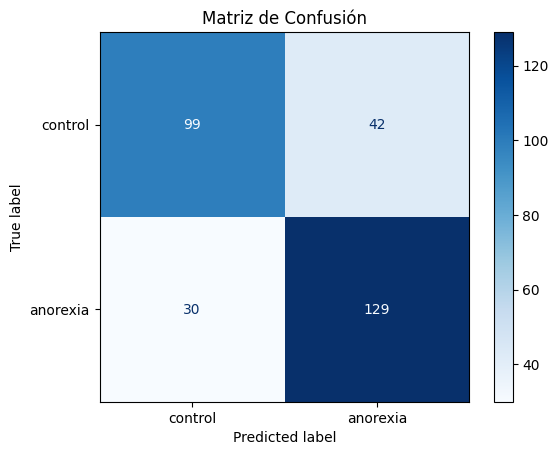

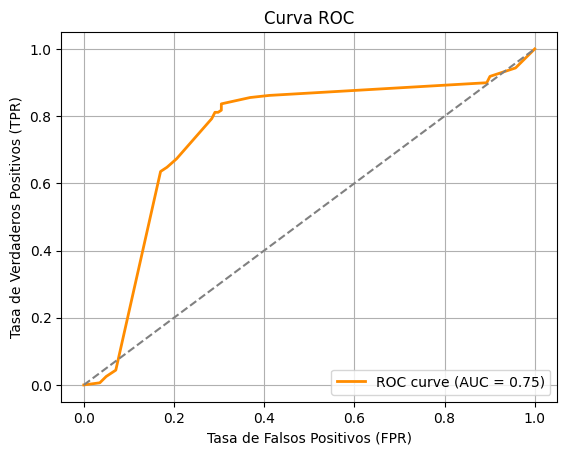

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import seaborn as sns

def evaluar_modelo_con_graficas(clf, X_test, y_test):
    """
    Función que evalúa el modelo:
    - AUC
    - Reporte de clasificación
    - Matriz de confusión
    - Curva ROC

    Parámetros:
    - clf: modelo entrenado
    - X_test: features de prueba
    - y_test: etiquetas verdaderas
    """

    y_pred = dt.predict(X_test)
    y_prob = dt.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_prob)
    print(f"AUC: {auc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=["control", "anorexia"]))

    conf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=["control", "anorexia"])
    disp.plot(cmap="Blues")
    plt.title("Matriz de Confusión")
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {auc:.2f})")
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

evaluar_modelo_con_graficas(dt, X_test, y_test)

# Test con datos nuevos

In [27]:
import pandas as pd

test_fold1 = pd.read_csv("/content/data_test_fold2 - anorexia(in).csv")

In [28]:
test_fold1["clean_text_lemma"] = test_fold1["tweet_text"].apply(clean_text_lemmatization)

In [29]:
test_fold1.head()

,user_id,tweet_id,tweet_text,class,clean_text_lemma
0,user1502,c1a446a05987,no es malo ayunar 20 dias al mes ... ya que no...,anorexia,malo ayunar mes continuo bomitar
1,user1503,bfdce07b546c,"¡7 días, 7 razones para entrenar!\n-\nLlegamos...",control,razón entrenar llegar domingo wow acabar seman...
2,user1504,860a2eced012,"#Cookies de avena, banana (o plátano) y cacao ...",control,cooki avena banán plátano cacao súper sano fac...
3,user1505,b745c4311c24,cuanto pesan ustedes\nyo 29,anorexia,pesar
4,user1506,fdcb32f44ce7,Como bajar peso comiendo sin parar.\n #Tips,anorexia,bajar peso comer parar tip


In [30]:
X_f1, y_f1 = preparar_datos(test_fold1)

Promedio de letras por tweet: 71.72


In [31]:
X_f1

,clean_text_lemma
0,malo ayunar mes continuo bomitar
1,razón entrenar llegar domingo wow acabar seman...
2,cooki avena banán plátano cacao súper sano fac...
3,pesar
4,bajar peso comer parar tip
...,...
245,conocer alfa espíritu entrega ayudar lograr ob...
246,whatsapp escondite comunidad anorexia bulimio
247,barbyaranda anaymiar querer cuerpo
248,desayuno martes empezar acabar adelgazar lowca...


In [32]:
y_f1

,class
0,1
1,0
2,0
3,1
4,1
...,...
245,0
246,0
247,1
248,0


In [33]:
# 1. Generar los embeddings para X_f1
X_f1_embed = embedder.encode(X_f1["clean_text_lemma"].tolist(), show_progress_bar=True)

# 2. Calcular sentimiento
sentiment_scores = X_f1["clean_text_lemma"].apply(lambda text: TextBlob(str(text)).sentiment.polarity)
sentiment_scores = sentiment_scores.apply(lambda x: (x + 1) / 2) * 3  # escalar y amplificar

# 3. Concatenar embeddings + sentimiento
X_f1_final = np.hstack([X_f1_embed, np.array(sentiment_scores).reshape(-1, 1)])

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

AUC: 0.8083

Classification Report:
              precision    recall  f1-score   support

     control       0.80      0.72      0.75       116
    anorexia       0.77      0.84      0.81       134

    accuracy                           0.78       250
   macro avg       0.79      0.78      0.78       250
weighted avg       0.79      0.78      0.78       250



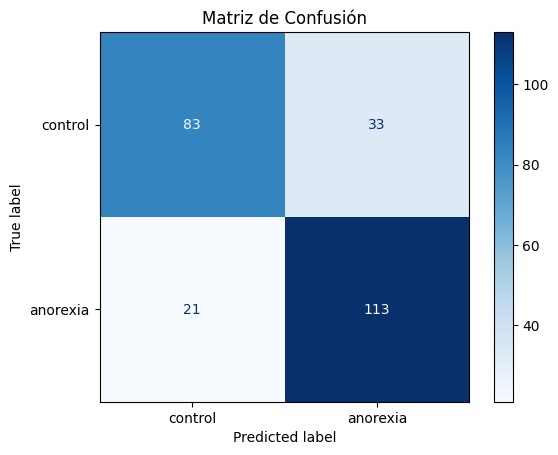

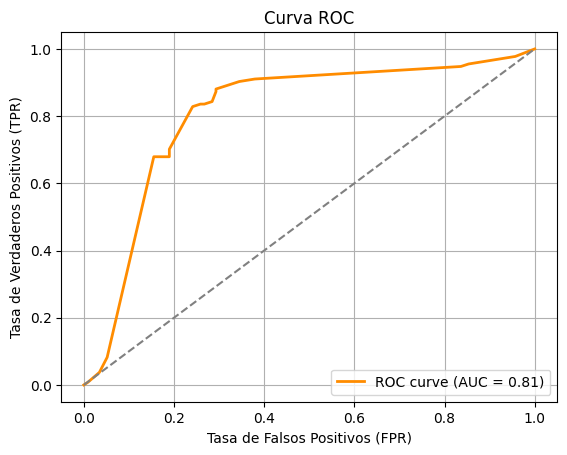

In [34]:
evaluar_modelo_con_graficas(dt, X_f1_final, y_f1)

# Pruebas Unitarias

Para garantizar la funcionalidad, confiabilidad y calidad del código desarrollado para el procesamiento y modelado de texto, se implementaron pruebas unitarias

In [35]:
import unittest


class TestCleanText(unittest.TestCase):

    def test_quitar_url(self):
        self.assertNotIn("http", clean_text_lemmatization("visita https://ejemplo.com"))

    def test_lower(self):
        result = clean_text_lemmatization("HOLA MUNDO")
        self.assertEqual(result, result.lower())

    def test_sin_puntuacion(self):
        result = clean_text_lemmatization("¡Hola, mundo!")
        self.assertNotIn("¡", result)
        self.assertNotIn(",", result)

    def test_lemmatizacion(self):
        result = clean_text_lemmatization("Estoy corriendo al parque")
        self.assertIn("correr", result)

    def test_stopwords_fuera(self):
        result = clean_text_lemmatization("Ella es la mejor")
        self.assertNotIn("ella" or "es" or "la", result)

    def test_hashtags(self):
        result = clean_text_lemmatization("Estoy #Motivado")
        self.assertIn("motivado", result)
        self.assertNotIn("#", result)

    def test_entrada_numerica(self):
        result = clean_text_lemmatization(123456)
        self.assertEqual(result, "")

    def test_espacios(self):
        result = clean_text_lemmatization("   hola     mundo    ")
        self.assertNotIn("  ", result)

unittest.main(argv=[''], verbosity=2, exit=False)


test_entrada_numerica (__main__.TestCleanText.test_entrada_numerica) ... ok
test_espacios (__main__.TestCleanText.test_espacios) ... ok
test_hashtags (__main__.TestCleanText.test_hashtags) ... ok
test_lemmatizacion (__main__.TestCleanText.test_lemmatizacion) ... ok
test_lower (__main__.TestCleanText.test_lower) ... ok
test_quitar_url (__main__.TestCleanText.test_quitar_url) ... ok
test_sin_puntuacion (__main__.TestCleanText.test_sin_puntuacion) ... ok
test_stopwords_fuera (__main__.TestCleanText.test_stopwords_fuera) ... ok

----------------------------------------------------------------------
Ran 8 tests in 0.064s

OK


In [36]:
class TestPrepararDatos(unittest.TestCase):

    def setUp(self):
        self.data = pd.DataFrame({
            'clean_text_lemma': ['me gusta comer', 'comer poco adelgazar', 'feliz adelgazar comer sano'],
            'class': ['control', 'anorexia', 'anorexia']
        })

    def test_map_clases_correctamente(self):
        _, y = preparar_datos(self.data.copy())
        self.assertListEqual(sorted(y.dropna().unique().tolist()), [0, 1])

    def test_output_formato_correcto(self):
        X, y = preparar_datos(self.data.copy())
        self.assertTrue(isinstance(X, pd.DataFrame))
        self.assertTrue(isinstance(y, pd.Series))
        self.assertEqual(X.shape[0], 3)
        self.assertEqual(y.shape[0], 3)
        self.assertIn('clean_text_lemma', X.columns)

    def test_promedio_letras(self):
      data_2 = self.data.copy()
      letras_esperadas = data_2['clean_text_lemma'].apply(lambda x: len(str(x).replace(" ", ""))).mean()
      preparar_datos(data_2)
      letras_obtenidas = data_2['clean_text_lemma'].apply(lambda x: len(str(x).replace(" ", ""))).mean()
      self.assertAlmostEqual(letras_obtenidas, letras_esperadas, places=2)


unittest.main(argv=[''], verbosity=2, exit=False)

test_entrada_numerica (__main__.TestCleanText.test_entrada_numerica) ... ok
test_espacios (__main__.TestCleanText.test_espacios) ... ok
test_hashtags (__main__.TestCleanText.test_hashtags) ... ok
test_lemmatizacion (__main__.TestCleanText.test_lemmatizacion) ... ok
test_lower (__main__.TestCleanText.test_lower) ... ok
test_quitar_url (__main__.TestCleanText.test_quitar_url) ... ok
test_sin_puntuacion (__main__.TestCleanText.test_sin_puntuacion) ... ok
test_stopwords_fuera (__main__.TestCleanText.test_stopwords_fuera) ... ok
test_map_clases_correctamente (__main__.TestPrepararDatos.test_map_clases_correctamente) ... ok
test_output_formato_correcto (__main__.TestPrepararDatos.test_output_formato_correcto) ... ok
test_promedio_letras (__main__.TestPrepararDatos.test_promedio_letras) ... ok

----------------------------------------------------------------------
Ran 11 tests in 0.071s

OK


Promedio de letras por tweet: 17.67
Promedio de letras por tweet: 17.67
Promedio de letras por tweet: 17.67


In [37]:
from numpy import ndarray

class TestVectorizarConSentimiento(unittest.TestCase):

    def setUp(self):
        self.X_text = pd.Series([
            "comer sano feliz",
            "odio mi cuerpo",
            "me siento normal"
        ])

    def test_vectorizer_devuelto(self):
        _, vectorizer = vectorizar_con_sentimiento(self.X_text)
        self.assertIsNotNone(vectorizer)
        self.assertTrue(hasattr(vectorizer, 'transform'))

        def test_sentimiento_amplificado(self): # Se Transforma el X para que se
          X_final_amp, _ = vectorizar_con_sentimiento(self.X_text, amplify_sentiment=True)
          X_final_std, _ = vectorizar_con_sentimiento(self.X_text, amplify_sentiment=False)

          X_final_amp = X_final_amp.tocsr()
          X_final_std = X_final_std.tocsr()

          col_amp = X_final_amp[:, -1].toarray()
          col_std = X_final_std[:, -1].toarray()

          self.assertTrue((col_amp > col_std).all())


    def test_dimensiones_correctas(self):
        X_final, vectorizer = vectorizar_con_sentimiento(self.X_text, max_features=10)
        self.assertEqual(X_final.shape[0], 3)
        self.assertEqual(X_final.shape[1], 11)


unittest.main(argv=[''], verbosity=2, exit=False)

test_entrada_numerica (__main__.TestCleanText.test_entrada_numerica) ... ok
test_espacios (__main__.TestCleanText.test_espacios) ... ok
test_hashtags (__main__.TestCleanText.test_hashtags) ... ok
test_lemmatizacion (__main__.TestCleanText.test_lemmatizacion) ... ok
test_lower (__main__.TestCleanText.test_lower) ... ok
test_quitar_url (__main__.TestCleanText.test_quitar_url) ... ok
test_sin_puntuacion (__main__.TestCleanText.test_sin_puntuacion) ... ok
test_stopwords_fuera (__main__.TestCleanText.test_stopwords_fuera) ... ok
test_map_clases_correctamente (__main__.TestPrepararDatos.test_map_clases_correctamente) ... ok
test_output_formato_correcto (__main__.TestPrepararDatos.test_output_formato_correcto) ... ok
test_promedio_letras (__main__.TestPrepararDatos.test_promedio_letras) ... ok
test_dimensiones_correctas (__main__.TestVectorizarConSentimiento.test_dimensiones_correctas) ... ERROR
test_vectorizer_devuelto (__main__.TestVectorizarConSentimiento.test_vectorizer_devuelto) ... ERRO

Promedio de letras por tweet: 17.67
Promedio de letras por tweet: 17.67
Promedio de letras por tweet: 17.67


In [38]:
import warnings
from sklearn.datasets import make_classification

warnings.filterwarnings("ignore")

class TestEvaluacionModelo(unittest.TestCase):

    @classmethod
    def setUpClass(cls):
        X, y = make_classification(
            n_samples=200,
            n_features=20,
            n_informative=10,
            n_redundant=5,
            random_state=42
        )
        cls.X_train, cls.X_test, cls.y_train, cls.y_test = train_test_split(
            X, y, test_size=0.3, random_state=42
        )

        cls.clf = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
        cls.clf.fit(cls.X_train, cls.y_train)


    def test_predicciones_no_nulas(self):
        y_pred = self.clf.predict(self.X_test)
        self.assertEqual(len(y_pred), len(self.y_test))
        self.assertIn(y_pred[0], [0, 1])

    def test_probabilidades_validas(self):
        y_prob = self.clf.predict_proba(self.X_test)
        self.assertEqual(y_prob.shape[1], 2)
        self.assertTrue((y_prob >= 0).all() and (y_prob <= 1).all())

    def test_funcion_evaluacion_sin_error(self):
        try:
            evaluar_modelo_con_graficas(self.clf, self.X_test, self.y_test)
        except Exception as e:
            self.fail(f"La función evaluar_modelo_con_graficas lanzó un error inesperado: {e}")

if __name__ == "__main__":
    unittest.main(argv=[''], verbosity=2, exit=False)


test_entrada_numerica (__main__.TestCleanText.test_entrada_numerica) ... ok
test_espacios (__main__.TestCleanText.test_espacios) ... ok
test_hashtags (__main__.TestCleanText.test_hashtags) ... ok
test_lemmatizacion (__main__.TestCleanText.test_lemmatizacion) ... ok
test_lower (__main__.TestCleanText.test_lower) ... ok
test_quitar_url (__main__.TestCleanText.test_quitar_url) ... ok
test_sin_puntuacion (__main__.TestCleanText.test_sin_puntuacion) ... ok
test_stopwords_fuera (__main__.TestCleanText.test_stopwords_fuera) ... ok
setUpClass (__main__.TestEvaluacionModelo) ... ERROR
test_map_clases_correctamente (__main__.TestPrepararDatos.test_map_clases_correctamente) ... ok
test_output_formato_correcto (__main__.TestPrepararDatos.test_output_formato_correcto) ... ok
test_promedio_letras (__main__.TestPrepararDatos.test_promedio_letras) ... 

Promedio de letras por tweet: 17.67
Promedio de letras por tweet: 17.67
Promedio de letras por tweet: 17.67


ok
test_dimensiones_correctas (__main__.TestVectorizarConSentimiento.test_dimensiones_correctas) ... ERROR
test_vectorizer_devuelto (__main__.TestVectorizarConSentimiento.test_vectorizer_devuelto) ... ERROR

ERROR: setUpClass (__main__.TestEvaluacionModelo)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-38-1236792553>", line 21, in setUpClass
    cls.clf = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
              ^^^^^^^^^^^^^
NameError: name 'XGBClassifier' is not defined

ERROR: test_dimensiones_correctas (__main__.TestVectorizarConSentimiento.test_dimensiones_correctas)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-37-72511453>", line 31, in test_dimensiones_correctas
    X_final, vectorizer = vectorizar_con_sentimiento(self.X_text, max_features=10)
                          ^^^^^^^^^^^